In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from tqdm import tqdm



/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot NIPS MNIST alpha

In [100]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0213(0.0212);   PSNR: 16.73 (16.73);   Rec FID: 32.15 (31.16)
MSE: 0.0086(0.0083);   PSNR: 20.65 (20.80);   Rec FID: 11.07 (10.34)
MSE: 0.0042(0.0039);   PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0022(0.0021);   PSNR: 26.50 (26.84);   Rec FID: 7.18 (6.51)
"""
str_gen_fid  = """
FID gm1: 59.33;   FID gm4: 43.61
FID gm1: 34.59;   FID gm4: 21.20
FID gm1: 31.29;   FID gm4: 17.89
FID gm1: 36.97;   FID gm4: 21.81
"""
alpha_list = [1/(10**(i+1)) for i in range(4)]


model_type = 'LRAE'
str_rec_metrics = """
MSE: 0.0035(0.0033);  PSNR: 24.60 (24.76);    Rec FID: 8.50 (7.83)
MSE: 0.0024(0.0023);   PSNR: 26.17 (26.48);   Rec FID: 7.97 (7.31)
MSE: 0.0031(0.0028);   PSNR: 25.05 (25.54);   Rec FID: 7.99 (7.32)
MSE: 0.0036(0.0033);   PSNR: 24.42 (24.75);   Rec FID: 8.08 (7.49)
"""
str_gen_fid  = """
FID gm1: 27.79;   FID gm4: 16.51
FID gm1: 31.39;   FID gm4: 18.98
FID gm1: 30.92;   FID gm4: 18.16
FID gm1: 32.37;   FID gm4: 19.47
"""
alpha_list = [3.2, 1, 0.5] +  [1/(10**(i+1)) for i in range(4)]



print(alpha_list)

[3.2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]


In [118]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0042(0.0039); PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0045 (0.0043);   PSNR: 23.47 (23.62);   Rec FID: 9.03 (8.39)
MSE: 0.0049 (0.0048);   PSNR: 23.11 (23.18);   Rec FID: 9.13 (8.51)
MSE: 0.0058 (0.0057);   PSNR: 22.40 (22.42);   Rec FID: 10.08 (9.51)
MSE: 0.0069 (0.0070);   PSNR: 21.59 (21.56);   Rec FID: 11.73 (11.32)
"""
str_gen_fid  = """
FID gm1: 31.29; FID gm4: 17.89
FID gm1: 32.75;   FID gm4: 19.90
FID gm1: 36.48;   FID gm4: 21.03
FID gm1: 37.33;   FID gm4: 24.63
FID gm1: 41.17;   FID gm4: 27.53
"""

alpha_list = [32, 128, 256, 512, 1024]


In [119]:
def split_metric_test_train(metric):
    metric_name = metric.strip().split(':')[0]
    test_train = metric.strip().split(':')[1].strip().strip(')').split('(')
    test = float(test_train[0].strip())
    train = float(test_train[1].strip())
    # print(metric_name, test, train)
    return test, train, metric_name


def split_metric(metric):
    metric_name = metric.strip().split(':')[0]
    test = metric.strip().split(':')[1].strip()
    test = float(test)
    return test, metric_name

def udpate_list_dict(key, value, dict_={}):
    if key not in dict_.keys():
        dict_[key] = []
    dict_[key] += [value]
    return dict_ 


In [120]:

data_dict = {}

lines = str_rec_metrics.strip().split('\n')
for line in lines:
    metrics = line.strip().split(';')
    for i, metric in enumerate(metrics):
        test, train, metric_name = split_metric_test_train(metric)
        key = metric_name+'_train'
        udpate_list_dict( metric_name+'_test', test, dict_=data_dict)
        udpate_list_dict( metric_name+'_train', train, dict_=data_dict)
 
lines = str_gen_fid.strip().split('\n')       
for line in lines:
    metrics = line.strip().split(';')
    for i, metric in enumerate(metrics):
        value, metric_name = split_metric(metric)
        udpate_list_dict( metric_name, value, dict_=data_dict)
        # udpate_list_dict( metric_name+'_train', train, dict_=data_dict)       
        
        
        
data_dict




{'MSE_test': [0.0042, 0.0045, 0.0049, 0.0058, 0.0069],
 'MSE_train': [0.0039, 0.0043, 0.0048, 0.0057, 0.007],
 'PSNR_test': [23.81, 23.47, 23.11, 22.4, 21.59],
 'PSNR_train': [24.04, 23.62, 23.18, 22.42, 21.56],
 'Rec FID_test': [8.99, 9.03, 9.13, 10.08, 11.73],
 'Rec FID_train': [8.28, 8.39, 8.51, 9.51, 11.32],
 'FID gm1': [31.29, 32.75, 36.48, 37.33, 41.17],
 'FID gm4': [17.89, 19.9, 21.03, 24.63, 27.53]}

Text(0.5, 0.98, 'VAE')

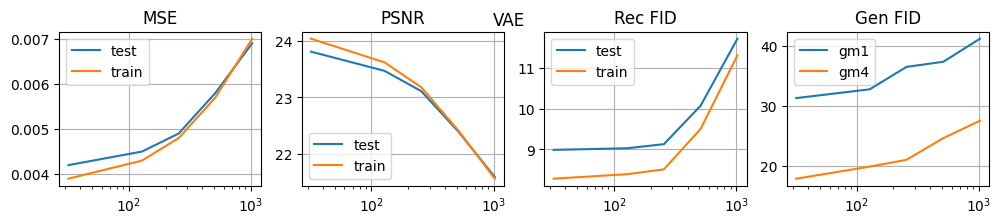

In [125]:
# MSE
plt.figure(figsize=[12, 2])
plt.subplot(1, 4, 1)
keys = ['MSE_test','MSE_train']
for key in keys:
    plt.plot(alpha_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
plt.gca().set_xscale('log')
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()


# PSNR
plt.subplot(1, 4, 2)
keys = ['PSNR_test','PSNR_train']
for key in keys:
    plt.plot(alpha_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
plt.gca().set_xscale('log')
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()

# Rec FID
plt.subplot(1, 4, 3)
keys = ['Rec FID_test','Rec FID_train']
for key in keys:
    plt.plot(alpha_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
plt.gca().set_xscale('log')
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()


# Gen FID
# plt.figure(figsize=[4, 2])
plt.subplot(1, 4, 4)
keys = ['FID gm1','FID gm4']
for key in keys:
    plt.plot(alpha_list, data_dict[key], label=key.split(' ')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
plt.gca().set_xscale('log')
# plt.gca().invert_xaxis()
plt.title('Gen '+ keys[0].split(' ')[0])
plt.grid()
plt.legend()

plt.suptitle(model_type)

# others

In [117]:

b = {1:1, 2:2} | {3:3}
b

{1: 1, 2: 2, 3: 3}